# Data Merging

We have two sources of data: (a) **Justia data** (includes the text of the syllabi) and (b) **Supreme Court Database data** (includes metadata, i.e. voting outcomes and manually tagged issue areas). The best (yields most coverage) way to merge these two data sets is most easily done via the U.S. cite colume, which we scraped via the URLs for the Justia data. <br>

However, this task becomes somewhat nontrivial since the Supreme Court Database data has null fields for the U.S. cite column for years 2010 and beyond. This is because the notations format for Supreme Court cases transitioned during this year (Vol. 558). We can fix this missing data issue by scraping a mapped list (docket number to U.S. cite) via Wikipedia's comprehensive list of Supreme Court case citations by volume.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option("display.width", 500)
pd.set_option("display.max_columns", 100)
pd.set_option("display.notebook_repr_html", True)
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

### Incorporating Text Data from Justia
To begin, we upload our main data source: syllabi of Supreme Court cases. A syllabus is the official summary of a Supreme Court decision, and is published by the Supreme Court together with the justices' opinions. Our sample is all Supreme Court cases since 1946. This is about 11,000 cases (an enormous amount of text), so we randomly sample 20% of these cases to make the problem more tractable. 

In [2]:
# read csv of syllabi to dataframe
justia_df = pd.read_csv("final_justia_data_merge.csv")
justia_df.head()

,full_cite,text,url,us_cite,year,case
0,Eagles v. Samuels 329 U.S. 304 (1946),"Eagles v. Samuels No. 59 Argued November 21, 1...",https://supreme.justia.com/cases/federal/us/32...,329 U.S. 304,1946,Eagles v. Samuels
1,Eagles v. Horowitz 329 U.S. 317 (1946),"Eagles v. Horowitz No. 58 Argued November 21, ...",https://supreme.justia.com/cases/federal/us/32...,329 U.S. 317,1946,Eagles v. Horowitz
2,Labor Board v. A. J. Tower Co. 329 U.S. 324 (1...,Labor Board v. A. J. Tower Co. No. 60 Argued N...,https://supreme.justia.com/cases/federal/us/32...,329 U.S. 324,1946,Labor Board v. A. J. Tower Co.
3,Gibson v. United States 329 U.S. 338 (1946),Gibson v. United States No. 23 Argued January ...,https://supreme.justia.com/cases/federal/us/32...,329 U.S. 338,1946,Gibson v. United States
4,Illinois v. Campbell 329 U.S. 362 (1946),Illinois ex rel. Gordon v. Campbell No. 35 Arg...,https://supreme.justia.com/cases/federal/us/32...,329 U.S. 362,1946,Illinois v. Campbell


In [3]:
# ---------- randomly sample 20% of the justia data ----------

from random import sample
print "total number of cases: ", len(justia_df)

# create a unique case_id for each case
justia_df["case_id"] = justia_df.index

# randomly sample to get 20% of the cases 
sample_df = justia_df.loc[sample(justia_df.index, len(justia_df)/5)]
sample_df = sample_df.reset_index(drop=True)

# drop year column (will be duplicate)
sample_df = sample_df.drop("year",1)

total number of cases:  11224


### Refining Corpus by Text Length

We will explore the Justia data alone to see if there is any way we can automatically exclude opinions based on poor text quality. 

5th percentile:  123.15
25th percentile:  841.75
50th percentile:  2553.5
75th percentile:  4992.0
95th percentile:  7840.0


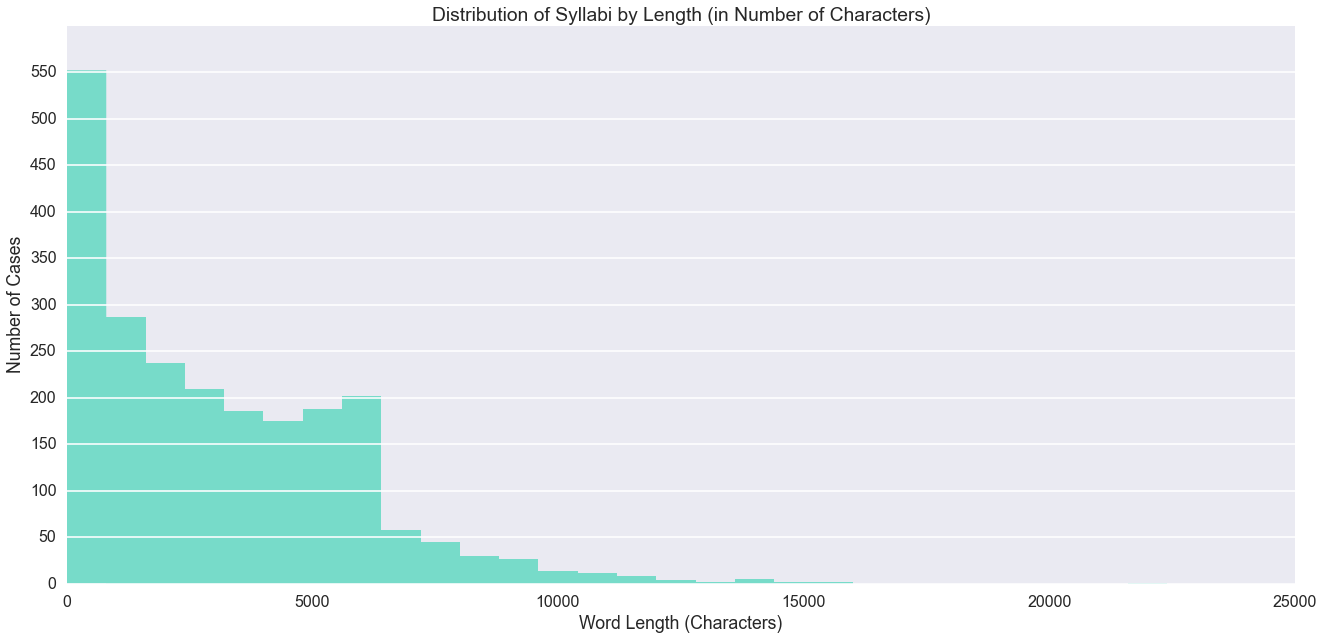

In [4]:
# get length of syllabi to determine which syllabi are undecided cases (ie, very short syllabi)
hist_textlength,textlength = [],[]
for index, row in sample_df.iterrows():
    l = len(str(row["text"]))
    textlength.append((l,row["case_id"]))
    hist_textlength.append(l)

# plot histogram of word length in chars
plt.figure(figsize=(22,10))
plt.grid(zorder=3)
plt.gca().xaxis.grid(False)
plt.hist(hist_textlength,bins=np.arange(0, 25000, 800),color="#77dbc9",linewidth=0,zorder=0)
plt.title("Distribution of Syllabi by Length (in Number of Characters)")
plt.yticks(np.arange(0,600,50))
plt.ylabel("Number of Cases")
plt.xlabel("Word Length (Characters)")

# print percentiles
p5 = np.percentile(hist_textlength, 5) 
p25 = np.percentile(hist_textlength, 25) 
p50 = np.percentile(hist_textlength, 50) 
p75 = np.percentile(hist_textlength, 75) 
p95 = np.percentile(hist_textlength, 95) 
print "5th percentile: ", p5
print "25th percentile: ", p25
print "50th percentile: ", p50
print "75th percentile: ", p75
print "95th percentile: ", p95

We see that there are a lot of syllabi with very few characters. This is because there are a number of syllabi of cases that were not actually decided; the syllabus simply consists of the case name and nothing more. We want to remove these cases from our dataset. In the following cell, we figure out what the appropriate cutoff length is by looking at cases with different numbers of characters (a proxy for number of words) by looking at syllabi with various numbers of characters.

In [5]:
# function to find the text length closest to a given length 
closest = lambda num: min(hist_textlength, key=lambda x:abs(x-num))
textlength_dict = dict(textlength)

# we find the case id corresponding to the closest number, and print the corresponding text
test_lengths = [200,300,400,500,600,700,800]
for length in test_lengths:
    print "%d characters: " % length + "\n----------"
    print sample_df[sample_df["case_id"]==textlength_dict[closest(length)]].iloc[0]["text"] + "\n"

200 characters: 
----------
 393 U.S. 1052   Bardish G. MORSE et al., petitioners,v. Charles B. BOSWELL, Commanding Officer, Fort George G. Meade, Maryland, et al.No. 764.   Supreme Court of the United States   January 20, 1969 

300 characters: 
----------
 BEATTIE v. CALIFORNIA.  ON PETITION FOR WRIT OF CERTIORARI TO THE DISTRICT COURT OF APPEAL OF  CALIFORNIA, FIRST APPELLATE DISTRICT. No. 556, Misc. Filed March 13, 1967.  Certiorari granted; vacated and remanded.  Petitioner pro se.  Thomas C. Lynch, Attorney General of California, for respondent.     

400 characters: 
----------
 106 S.CT. 3343 473 U.S. 935   Louie L. WAINWRIGHT, Secretary, Florida Department of Correctionsv. Stephen Todd BOOKER.   A-220.   Sept. 24, 1985.   For majority opinion see .    Justice POWELL, concurring.*   My vote was to grant Florida's application to vacate the stay of execution in this case. I write as it seems important to address two points raised by Justice MARSHALL's dissent.   I  

500 characte

Based on our method of spot-checking syllabi texts, there seems no clear cutoff point. Because there is no non-arbitrary way to create a threshold, we eliminate all cases with text of fewer than 400 characters. (such cases seem unlikely to contain meaningful text, and we note that, for example, the 800-character case does have some information that does not relate to the disclaimer).

In [6]:
# exclude cases with fewer than 400 characters
for case in textlength:
    if case[0]<400: 
        sample_df = sample_df[sample_df["case_id"]!=case[1]]      

sample_df = sample_df.reset_index(drop=True)

###Incorporating Metadata from the Supreme Court Database
Our second data source is the Supreme Court Database (SCDB), which contains various metadata (including pre-labeled issue areas, decision directions, and voting outcomes) of cases. We upload this data here. Because the SCDB data includes a diverse and large set of columns (50+) that are either repetitive or unrelated to our analysis, we can select columns to accommodate the scope of our project.

In [7]:
# convert csv to dataframe, keep useful columns
scdb_df = pd.read_csv("SCDB_2015_01_caseCentered_Citation.csv")
scdb_df = scdb_df[['caseId','docketId','usCite','docket','caseName','dateArgument','caseOriginState','jurisdiction',\
                   'issueArea','decisionDirection','decisionType','lawType','majOpinWriter','majVotes','minVotes']]

In [8]:
scdb_df.tail()

,caseId,docketId,usCite,docket,caseName,dateArgument,caseOriginState,jurisdiction,issueArea,decisionDirection,decisionType,lawType,majOpinWriter,majVotes,minVotes
8626,2014-071,2014-071-01,NaN,14-7955,GLOSSIP v. GROSS,4/29/2015,NaN,1,1,1,1,2,112,5,4
8627,2014-072,2014-072-01,NaN,14-185,MATA v. LYNCH,4/29/2015,NaN,1,9,2,1,3,114,8,1
8628,2014-073,2014-073-01,NaN,14-618,WOODS v. DONALD,NaN,NaN,1,2,1,2,3,NaN,9,0
8629,2014-074,2014-074-01,NaN,14-593,GRADY v. NORTH CAROLINA,NaN,38,1,1,2,2,2,NaN,9,0
8630,2014-075,2014-075-01,NaN,14-939,TAYLOR v. BARKES,NaN,NaN,1,2,1,2,3,NaN,9,0


As we can tell by inspecting the tail of the dataframe, the Supreme Court Database data does not have U.S. cites for cases held in 2010 and beyond. Because this is the column that is most reliable to merge the Justia data on, we will need to complete the SCDB database by mapping U.S. cites to docket IDs. One way to accomplish this is by scraping this map from the comprehensive Wikipedia list of Supreme Court citations by volume.

In [9]:
# ---------- create a list of U.S. cites and volumes to map to SCDB data ----------

from bs4 import BeautifulSoup
import requests as rq
import re

# wikipedia lists all scotus cases by volume; scrape docket number to match u.s. cite format
url_stem = "https://en.wikipedia.org/wiki/List_of_United_States_Supreme_Court_cases,_volume_"

# save U.S. cites and docket numbers
cites,cite_nums = [],[]

# for wikipedia pages before vol. 565, scrape unstructured list
for vol in range(558,565):
    soup = BeautifulSoup(rq.get(url_stem + str(vol)).text, "lxml")
    caselist = soup.find("div", attrs={"id":"mw-content-text"}).ul
    for case in caselist.findAll("li"):
        try:
            cite_num = case.text.split("No. ")[1][:-1]
        except IndexError:
            cite_num = case.text.split(", ")[1][:-1]
        cite_nums.append(cite_num)
        cites.append(str(vol) + " U.S. " + cite_num)

# for wikipedia pages vol. 565 and after, scrape table
for vol in range(565,576):
    soup = BeautifulSoup(rq.get(url_stem + str(vol)).text, "lxml")
    caselist = soup.find("table", attrs={"class":"wikitable plainlinks"})
    for cite in caselist.findAll("td", attrs={"style":"white-space:nowrap;"}):
        cite_num = cite.text
        cite_nums.append(cite_num)
        cites.append(str(vol) + " U.S. " + cite_num)

In [10]:
# create dataframe to merge U.S. cites 
cite_dict = {}
cite_dict["us_cite"] = cites
cite_dict["docket_num"] = cite_nums
citedf = pd.DataFrame(cite_dict)

In [11]:
# add a year column to SCDB data in order to subset 2010+ cases
scdb_df["year"] = [int(scdb_df["caseId"][x].split("-")[0]) for x in range(0,len(scdb_df))]
scdb_subset = scdb_df[scdb_df["year"] >= 2010]
scdb_merged = pd.merge(scdb_subset, citedf, left_on='docket', right_on='docket_num')

# merge the scraped mapped list with the 2010+ SCDB data
scdb_merged = scdb_merged.drop(["docket_num","usCite"],axis=1)
scdb_merged.rename(columns={"us_cite":"usCite"}, inplace=True)
scdb_merged = scdb_merged[['caseId','docketId','usCite','docket','caseName','dateArgument','caseOriginState','jurisdiction',\
                   'issueArea','decisionDirection','decisionType','lawType','majOpinWriter','majVotes','minVotes','year']]

# concatenate the updated 2010+ and pre-2010 SCDB data
final_scdb = pd.concat([scdb_df,scdb_merged])
final_scdb = final_scdb.reset_index()
final_scdb.tail()

,index,caseId,docketId,usCite,docket,caseName,dateArgument,caseOriginState,jurisdiction,issueArea,decisionDirection,decisionType,lawType,majOpinWriter,majVotes,minVotes,year
8963,332,2014-065,2014-065-01,575 U.S. 14-400,14-400,HARRIS v. VIEGELAHN,4/1/2015,NaN,1,8,2,1,3,109,9,0,2014
8964,333,2014-066,2014-066-01,575 U.S. 14-116,14-116,BULLARD v. BLUE HILLS BANK,4/1/2015,NaN,1,9,1,1,3,111,9,0,2014
8965,334,2014-073,2014-073-01,575 U.S. 14-618,14-618,WOODS v. DONALD,NaN,NaN,1,2,1,2,3,NaN,9,0,2014
8966,335,2014-074,2014-074-01,575 U.S. 14-593,14-593,GRADY v. NORTH CAROLINA,NaN,38,1,1,2,2,2,NaN,9,0,2014
8967,336,2014-075,2014-075-01,575 U.S. 14-939,14-939,TAYLOR v. BARKES,NaN,NaN,1,2,1,2,3,NaN,9,0,2014


In [12]:
# now we can successfully merge the Justia and SCDB data on U.S. cite
full_df = pd.merge(sample_df, final_scdb, left_on='us_cite', right_on='usCite')
full_df = full_df.drop(["index"],1)

In [13]:
# check that 2010+ cases are included
full_df.sort("year").tail()

,full_cite,text,url,us_cite,case,case_id,caseId,docketId,usCite,docket,caseName,dateArgument,caseOriginState,jurisdiction,issueArea,decisionDirection,decisionType,lawType,majOpinWriter,majVotes,minVotes,year
1122,"Integrity Staffing Solutions, Inc. v. Busk 574...","NOTE: Where it is feasible, a syllabus (headno...",https://supreme.justia.com/cases/federal/us/57...,574 U.S. 13-433,"Integrity Staffing Solutions, Inc. v. Busk",11098,2014-005,2014-005-01,574 U.S. 13-433,13-433,"INTEGRITY STAFFING SOLUTIONS, INC. v. BUSK",10/8/2014,NaN,1,7,1,1,3,108,9,0,2014
831,Equal Emp't Opportunity Comm'n v. Abercrombie ...,"NOTE: Where it is feasible, a syllabus (headno...",https://supreme.justia.com/cases/federal/us/57...,575 U.S. 14-86,Equal Emp't Opportunity Comm'n v. Abercrombie ...,11186,2014-046,2014-046-01,575 U.S. 14-86,14-86,EQUAL EMPLOYMENT OPPORTUNITY COMMISSION v. ABE...,2/25/2015,NaN,1,2,2,1,3,105,8,1,2014
93,Elonis v. United States 575 U.S. ___ (2015),"NOTE: Where it is feasible, a syllabus (headno...",https://supreme.justia.com/cases/federal/us/57...,575 U.S. 13-983,Elonis v. United States,11185,2014-024,2014-024-01,575 U.S. 13-983,13-983,ELONIS v. UNITED STATES,12/1/2014,NaN,1,1,2,1,6,111,8,1,2014
193,"Mach Mining, LLC v. Equal Emp't Opportunity Co...","NOTE: Where it is feasible, a syllabus (headno...",https://supreme.justia.com/cases/federal/us/57...,575 U.S. 13-1019,"Mach Mining, LLC v. Equal Emp't Opportunity Co...",11197,2014-053,2014-053-01,575 U.S. 13-1019,13-1019,"MACH MINING, LLC, v. EQUAL EMPLOYMENT OPPORTUN...",1/13/2015,NaN,1,9,2,1,3,114,9,0,2014
145,"Bank of America, N. A. v. Caulkett 575 U.S. __...","NOTE: Where it is feasible, a syllabus (headno...",https://supreme.justia.com/cases/federal/us/57...,575 U.S. 13-1421,"Bank of America, N. A. v. Caulkett",11184,2014-060,2014-060-01,575 U.S. 13-1421,13-1421,"BANK OF AMERICA, N.A. v. CAULKETT",3/24/2015,NaN,1,8,1,1,3,108,9,0,2014


In [14]:
# simplify data 
full_df = full_df.drop("caseName",1)

In [15]:
# save sample dataframe for various models
full_df.to_csv("sample_cases.csv", sep=',', encoding='utf-8',index=False)

### Incorporating SCDB into Full Data Set

We want to ultimately run the best models on the full data set, so we want to preemptively merge the SCDB metadata with the full data set. In order to do this, we just apply the methods above to the justia_df. 

In [59]:
justia_df = justia_df.drop("year",1)

In [60]:
# exclude cases with fewer than 400 characters
for case in textlength:
    if case[0]<400: 
        justia_df = justia_df[justia_df["case_id"]!=case[1]]      

justia_df = justia_df.reset_index(drop=True)

In [61]:
# merge the full Justia data set and SCDB data on U.S. cite
full_justia_df = pd.merge(justia_df, final_scdb, left_on='us_cite', right_on='usCite')
full_justia_df = full_justia_df.drop(["index"],1)

In [62]:
# simplify data 
full_justia_df = full_justia_df.drop("caseName",1)

In [63]:
# save sample dataframe for various models
full_justia_df.to_csv("all_cases.csv", sep=',', encoding='utf-8',index=False)

### Exploratory Analysis

We can conduct exploratory analysis using the Supreme Court Database data. It is interesting, for instance, to see how the cases are distributed along the axes of years, issue types (pre-labeled), majority and minority votes, and decision directions (a manually tagged column representing conservative and liberal opinions --- full documentation can be found [here](http://supremecourtdatabase.org/documentation.php?var=decisionDirection)).

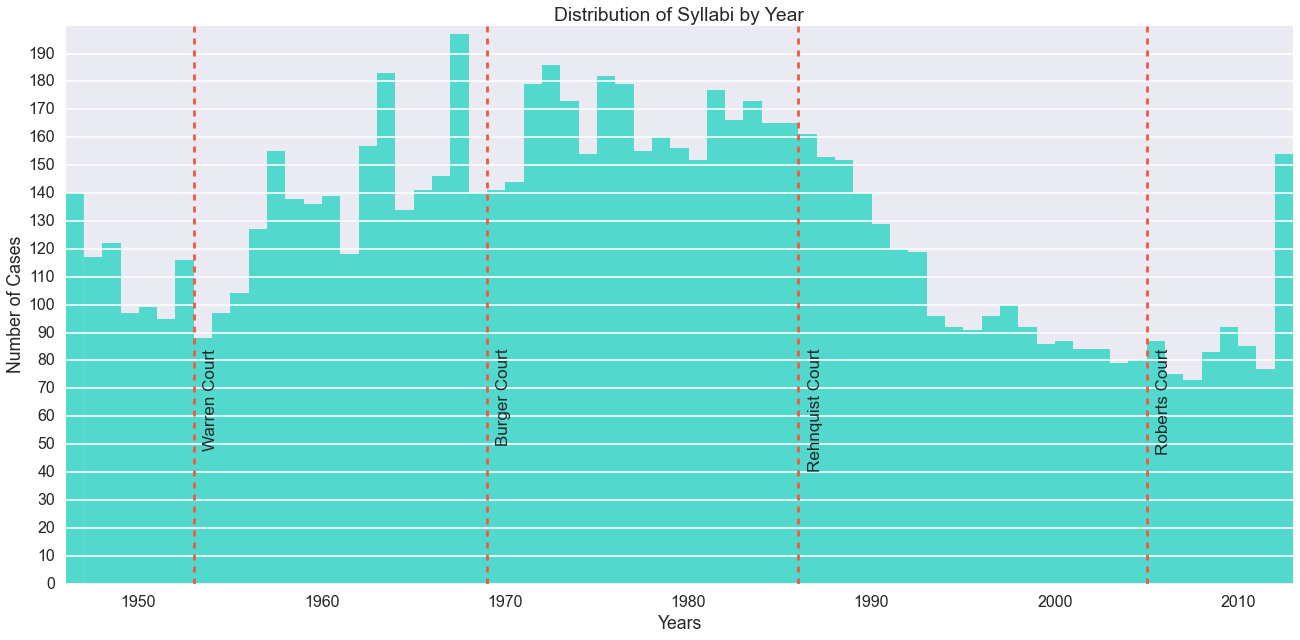

In [16]:
# plot distribution of all cases by year
plt.figure(figsize=(22,10))
plt.grid(zorder=3)
plt.gca().xaxis.grid(False)
plt.hist(scdb_df.year, bins=np.arange(min(scdb_df.year),max(scdb_df.year),1),color="#53d8ce",linewidth=0,zorder=0)
plt.title("Distribution of Syllabi by Year")
plt.yticks(np.arange(0,200,10))
plt.ylabel("Number of Cases")
plt.xlabel("Years")
plt.xlim((min(scdb_df.year),max(scdb_df.year)-1))

# plot court eras for context
plt.axvline(1953,color="#f4593d",linestyle="dashed")
plt.text(1953.5,80,"Warren Court",rotation=90,size=17)
plt.axvline(1969,color="#f4593d",linestyle="dashed")
plt.text(1969.5,80,"Burger Court",rotation=90,size=17)
plt.axvline(1986,color="#f4593d",linestyle="dashed")
plt.text(1986.5,80,"Rehnquist Court",rotation=90,size=17)
plt.axvline(2005,color="#f4593d",linestyle="dashed")
plt.text(2005.5,80,"Roberts Court",rotation=90,size=17)

plt.show()

We can see that most cases in our data set were published during the Burger Court, which lasted from 1969 to 1986. We can also see that the number of syllabis has declined substantially since the beginning of the Rehnquist court, led by Chief Justice William Rehnquist, who was considered a conservative.

In [17]:
# turn issue areas into dummy column
issue_areas = ["criminal procedure","civil rights","first amendment","due process","privacy","attorneys",
              "unions","economic activity","judicial power","federalism","interstate  amendment",
              "federal taxation","miscellaneous","private action"]

for issue, num in zip(issue_areas,range(1,15)):
    scdb_df[issue] = scdb_df.issueArea.apply(lambda x: 1 if x == num else 0)

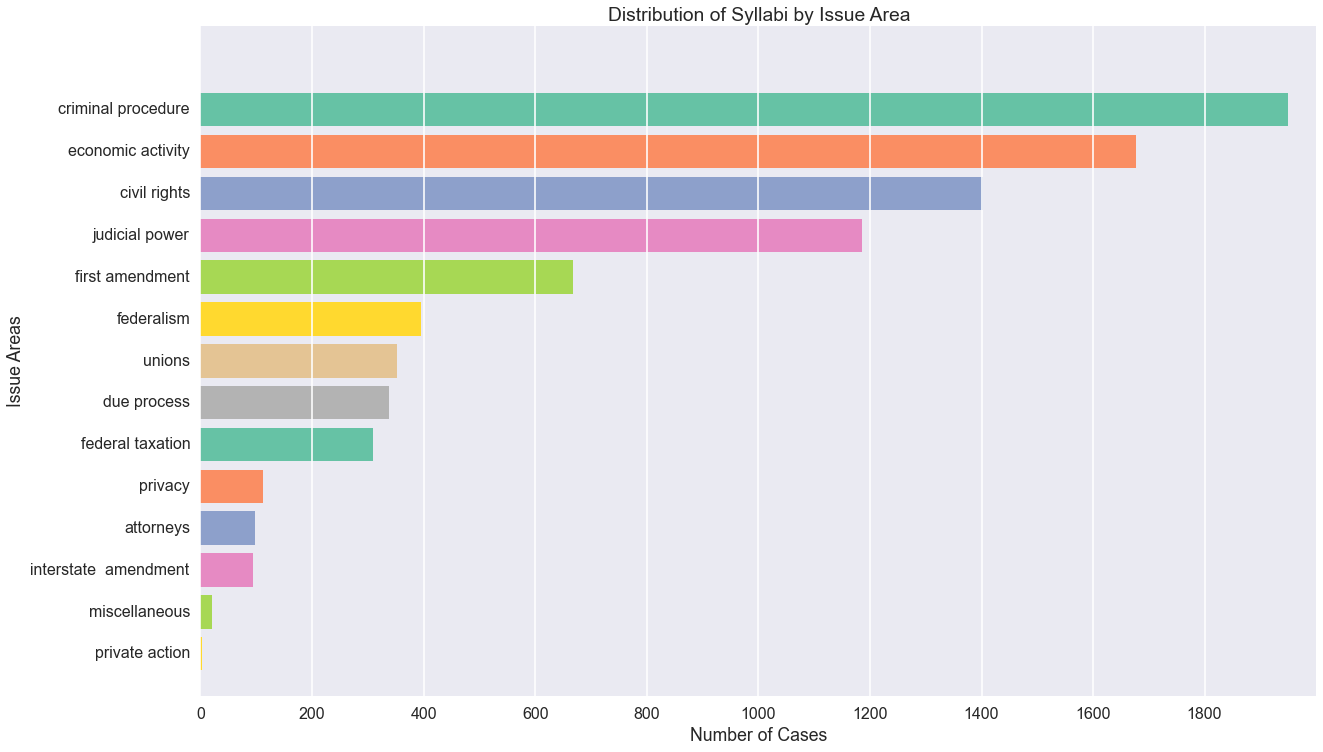

In [18]:
# plot distribution of all cases by issue type
import collections

issue_dict = {}
for issue in issue_areas:
    issue_dict[issue] = sum(scdb_df[issue])

sorted_dict = collections.OrderedDict()
sorted_vals = sorted(issue_dict.values(),reverse=True)
sorted_keys = sorted(issue_dict, key=issue_dict.get,reverse=True)
for key, val in zip(sorted_keys,sorted_vals):
    sorted_dict[key] = val

plt.figure(figsize=(20,12))
plt.grid(zorder=3)
plt.barh(range(len(sorted_dict)),sorted_dict.values(),align='center',color=sns.color_palette("Set2", 14),linewidth=0,zorder=0)
plt.gca().yaxis.grid(False)
plt.gca().invert_yaxis()
plt.yticks(range(len(sorted_dict)),sorted_dict.keys())
plt.xticks(np.arange(0,2000,200))
plt.title("Distribution of Syllabi by Issue Area")
plt.xlabel("Number of Cases")
plt.ylabel("Issue Areas")
plt.show()

We can see from the distribution of case issue areas that there is significant skew in representation of certain topics; for instance, the overwhelming majority of cases in the corpus are manually labeled (by the SCDB curators) as criminal procedure, economic activity, civil rights, and judicial power cases. It will be interesting to see if the supervised and unsupervised methods that we use for topic modeling produce similar distributions of predicted topics.

In [19]:
# turn decision directions into dummy column (conservative, liberal, neutral)
decision_areas = ["conservative","liberal","neutral"]

for decision, num in zip(decision_areas,range(1,4)):
    scdb_df[decision] = scdb_df.decisionDirection.apply(lambda x: 1 if x == num else 0)

In [23]:
# turn decision type into dummy column
for num in range(1,9):
    scdb_df["dec_" + str(num)] = scdb_df.decisionType.apply(lambda x: 1 if x == num else 0)

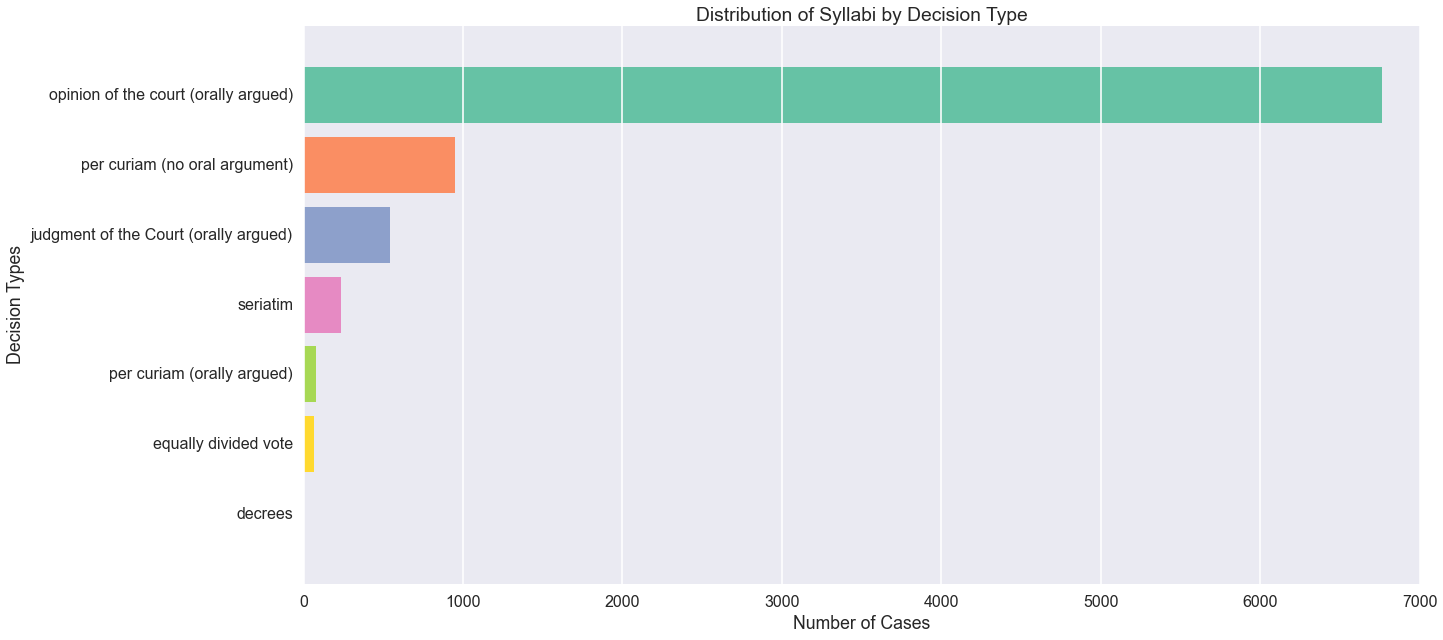

In [30]:
# plot distribution of all cases by issue type
types = ["opinion of the court (orally argued)", "per curiam (no oral argument)", "decrees", "equally divided vote",\
         "per curiam (orally argued)", "judgment of the Court (orally argued)", "seriatim"]
type_dict = {}
for dtype,label in zip(range(1,9),types):
    type_dict[label] = sum(scdb_df["dec_" + str(dtype)])

sorted_type_dict = collections.OrderedDict()
sorted_type_vals = sorted(type_dict.values(),reverse=True)
sorted_type_keys = sorted(type_dict, key=type_dict.get,reverse=True)
for key, val in zip(sorted_type_keys,sorted_type_vals):
    sorted_type_dict[key] = val

plt.figure(figsize=(20,10))
plt.grid(zorder=3)
plt.barh(range(len(sorted_type_dict)),sorted_type_dict.values(),align='center',color=sns.color_palette("Set2", 14),linewidth=0,zorder=0)
plt.gca().yaxis.grid(False)
plt.gca().invert_yaxis()
plt.yticks(range(len(sorted_type_dict)),sorted_type_dict.keys())
plt.title("Distribution of Syllabi by Decision Type")
plt.xlabel("Number of Cases")
plt.ylabel("Decision Types")
plt.show()

Finally, we see that most decisions in the corpus were delivered as oral arguments (as opposed to per curiam decisions or judgments of the court). This is reasonable, since opinions of the court are the most common form of Supreme Court resolutions.<br>

Now, we can check to see if the random sample that we collected contains a similar distribution to the ones above.

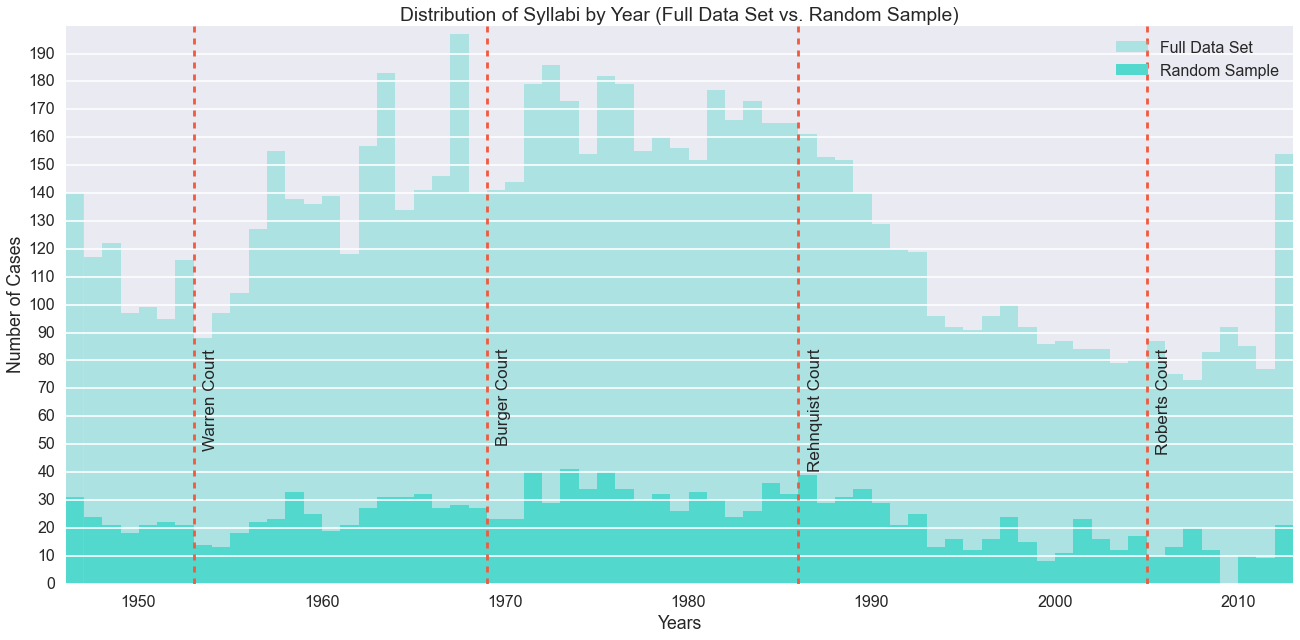

In [20]:
# plot distribution of all cases by year
plt.figure(figsize=(22,10))
plt.grid(zorder=3)
plt.gca().xaxis.grid(False)
plt.hist(scdb_df.year, bins=np.arange(min(scdb_df.year),max(scdb_df.year),1),color="#53d8ce",linewidth=0,alpha=0.4,zorder=0,label="Full Data Set")
plt.hist(full_df.year, bins=np.arange(min(full_df.year),max(full_df.year),1),color="#53d8ce",linewidth=0,zorder=0,label="Random Sample")
plt.title("Distribution of Syllabi by Year (Full Data Set vs. Random Sample)")
plt.yticks(np.arange(0,200,10))
plt.ylabel("Number of Cases")
plt.xlabel("Years")
plt.xlim((min(scdb_df.year),max(scdb_df.year)-1))
plt.legend()

# plot court eras for context
plt.axvline(1953,color="#f4593d",linestyle="dashed")
plt.text(1953.5,80,"Warren Court",rotation=90,size=17)
plt.axvline(1969,color="#f4593d",linestyle="dashed")
plt.text(1969.5,80,"Burger Court",rotation=90,size=17)
plt.axvline(1986,color="#f4593d",linestyle="dashed")
plt.text(1986.5,80,"Rehnquist Court",rotation=90,size=17)
plt.axvline(2005,color="#f4593d",linestyle="dashed")
plt.text(2005.5,80,"Roberts Court",rotation=90,size=17)

plt.show()

We can see that the yearly coverage of the random sample is relatively proportional to that of the full data set (with the exception of 2009, which is no reprsented in the random sample). We also see that, similar to the full data set, most cases represented in the sample are from the Burger Court.

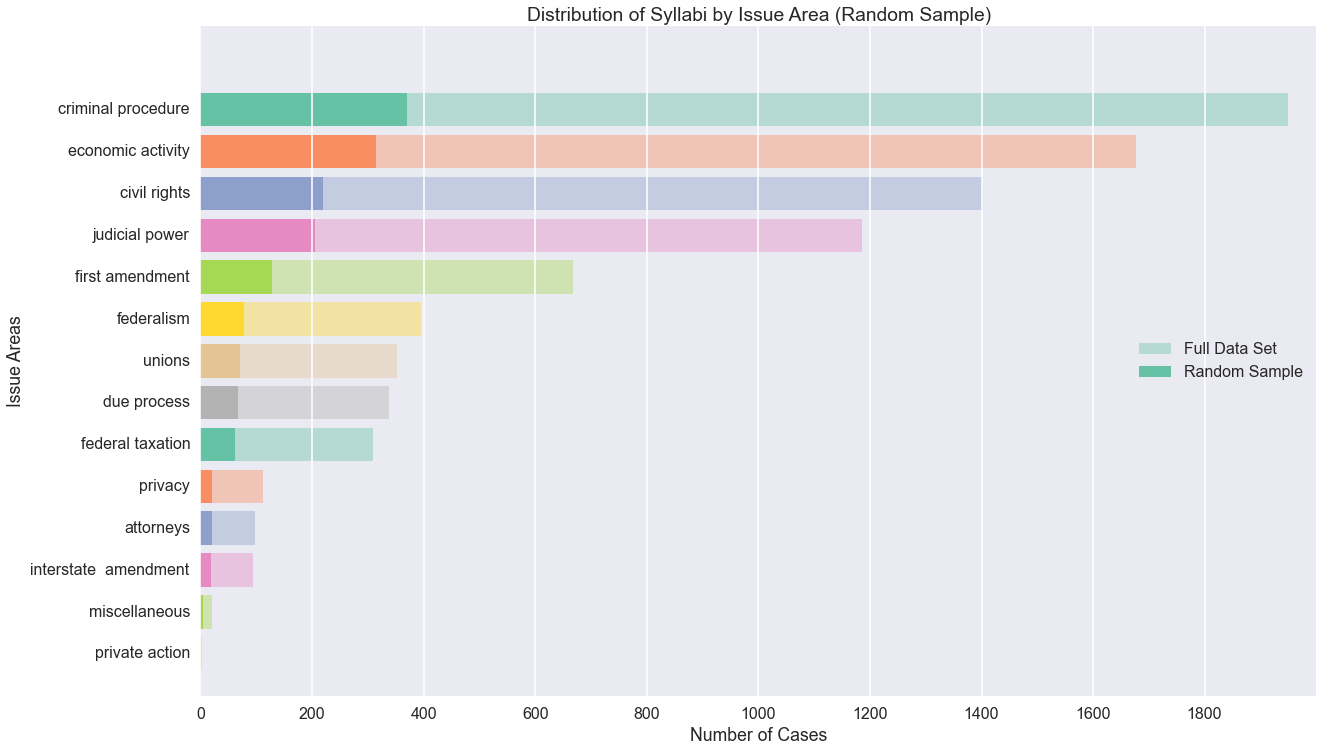

In [21]:
# turn issue areas into dummy column
for num in range(1,9):
    full_df["dec_" + str(num)] = full_df.decisionType.apply(lambda x: 1 if x == num else 0)
    
# plot distribution of all cases by issue type
samp_issue_dict = {}
for issue in issue_areas:
    samp_issue_dict[issue] = sum(full_df[issue])

samp_sorted_dict = collections.OrderedDict()
samp_sorted_vals = sorted(samp_issue_dict.values(),reverse=True)
samp_sorted_keys = sorted(samp_issue_dict, key=issue_dict.get,reverse=True)
for key, val in zip(samp_sorted_keys,samp_sorted_vals):
    samp_sorted_dict[key] = val

plt.figure(figsize=(20,12))
plt.grid(zorder=3)
plt.barh(range(len(sorted_dict)),sorted_dict.values(),align='center',color=sns.color_palette("Set2", 14),alpha=0.4,linewidth=0,zorder=0,label="Full Data Set")
plt.barh(range(len(samp_sorted_dict)),samp_sorted_dict.values(),align='center',color=sns.color_palette("Set2", 14),linewidth=0,zorder=0,label="Random Sample")
plt.gca().yaxis.grid(False)
plt.gca().invert_yaxis()
plt.yticks(range(len(sorted_dict)),sorted_dict.keys())
plt.title("Distribution of Syllabi by Issue Area (Random Sample)")
plt.xlabel("Number of Cases")
plt.ylabel("Issue Areas")
plt.legend(loc="center right")
plt.xticks(np.arange(0,2000,200))
plt.show()

We also notice that the distribution of cases across issue areas in the random sample is strikingly similar to that of the full data set; in fact, the ordinal ranking of issue area by volume of cases is preserved by the random sample. This is advantageous for modeling since we will be working with a collection of text documents that is representative of the entire population of Supreme Court cases with respect to issue area. Therefore, it will be unlikely that keywords associated with any topic exert a disproportionate influence upon the model. 

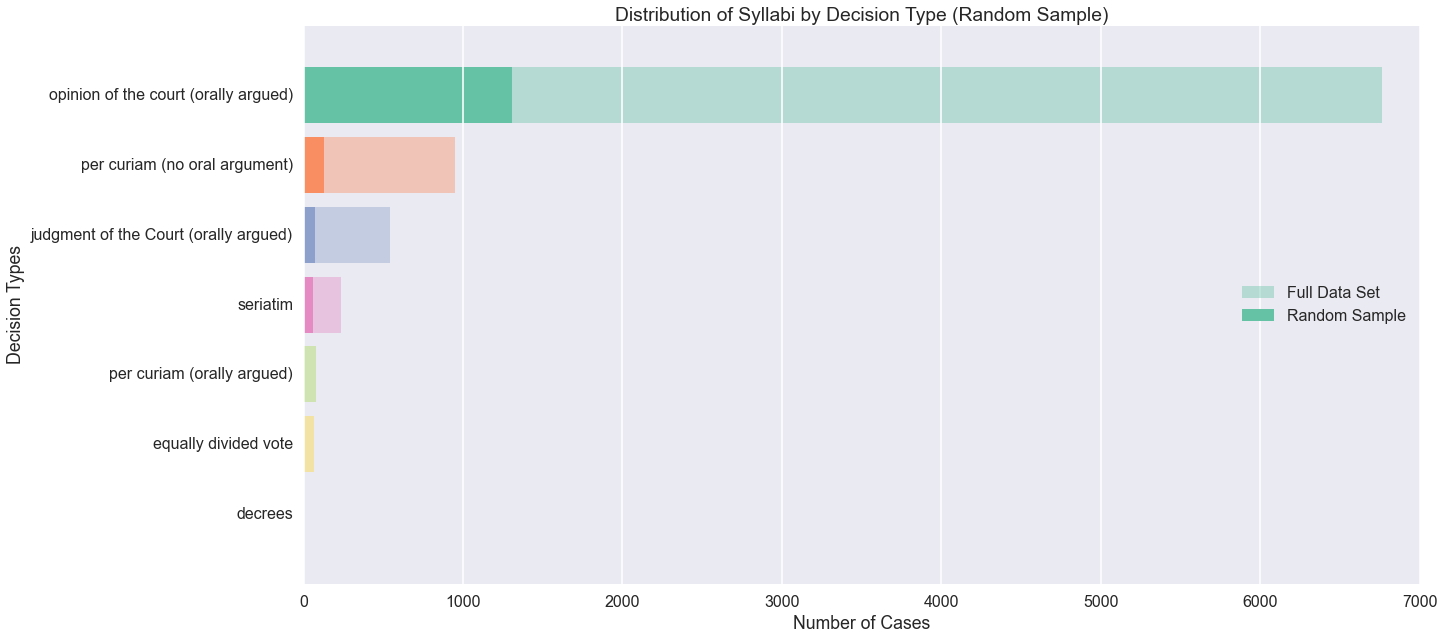

In [53]:
# turn decision types into dummy column
for num in range(1,9):
    full_df["dec_" + str(num)] = full_df.decisionType.apply(lambda x: 1 if x == num else 0)

# plot distribution of all cases by issue type
samp_type_dict = {}
for dtype,label in zip(range(1,9),types):
    samp_type_dict[label] = sum(full_df["dec_" + str(dtype)])

samp_sorted_type_dict = collections.OrderedDict()
samp_sorted_type_vals = sorted(samp_type_dict.values(),reverse=True)
samp_sorted_type_keys = sorted(samp_type_dict, key=samp_type_dict.get,reverse=True)
for key, val in zip(samp_sorted_type_keys,samp_sorted_type_vals):
    samp_sorted_type_dict[key] = val

plt.figure(figsize=(20,10))
plt.grid(zorder=3)
plt.barh(range(len(sorted_type_dict)),sorted_type_dict.values(),align='center',color=sns.color_palette("Set2", 14),alpha=0.4,linewidth=0,zorder=0,label="Full Data Set")
plt.barh(range(len(samp_sorted_type_dict)),samp_sorted_type_dict.values(),align='center',color=sns.color_palette("Set2", 14),linewidth=0,zorder=0,label="Random Sample")
plt.gca().yaxis.grid(False)
plt.gca().invert_yaxis()
plt.yticks(range(len(sorted_type_dict)),sorted_type_dict.keys())
plt.title("Distribution of Syllabi by Decision Type (Random Sample)")
plt.xlabel("Number of Cases")
plt.ylabel("Decision Types")
plt.legend(loc="center right")
plt.show()

Following the analysis above, we see that the decision types distribution of the full data set is also preserved in the random sample.

/Users/yunhanxu/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


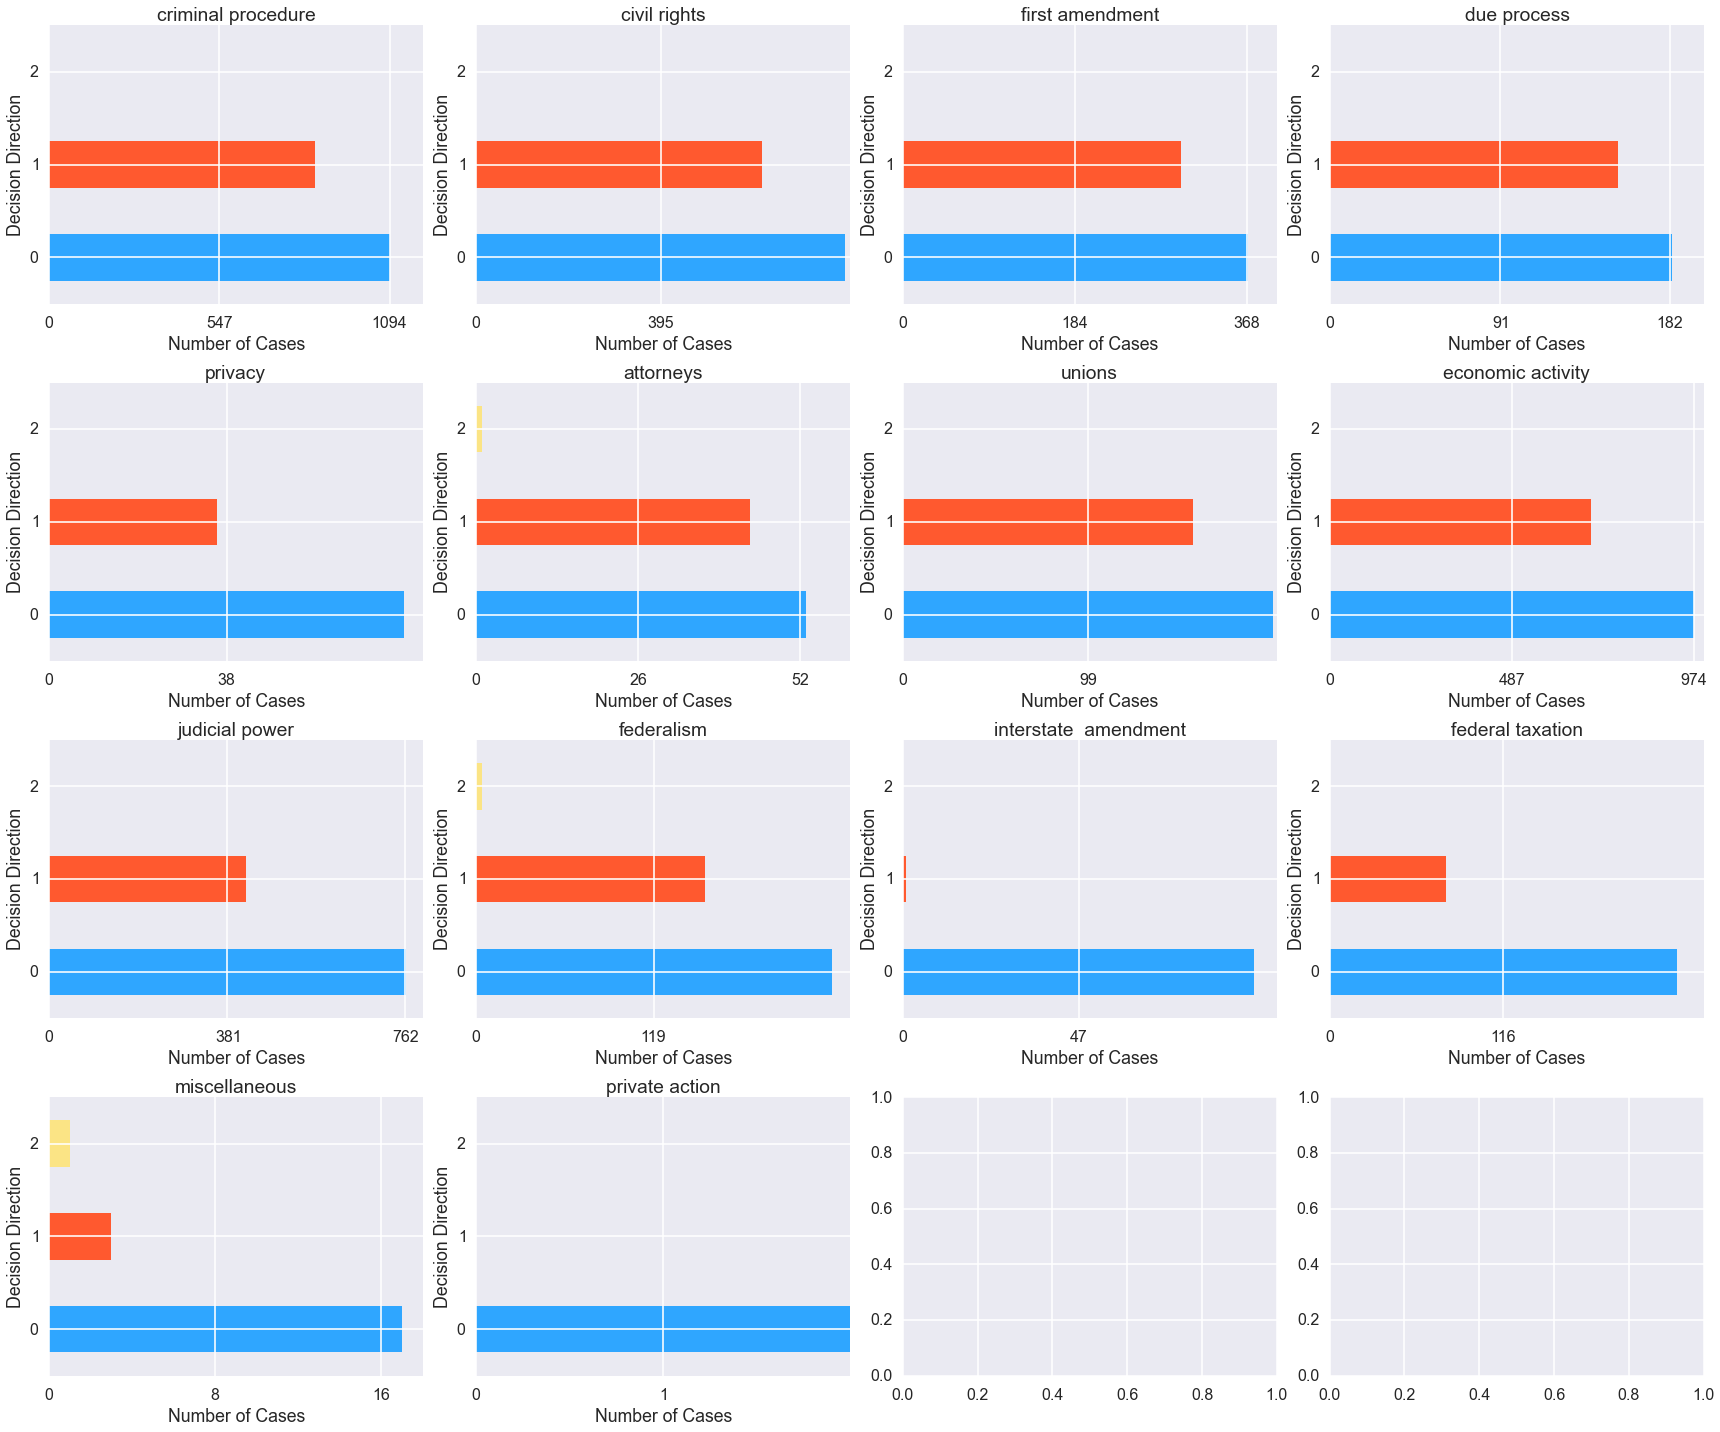

In [22]:
# plot distribution of partisanship by issue area 

# create subplot of 4 rows x 4 cols
fig, ax = plt.subplots(4, 4, figsize=(24, 20), tight_layout=True)

# index of issue area
x = 1

# iterate through rows, cols of subplot grid, populate with kde
for r in range(0,4):
    for c in range(0,4):
        ax[r][c].set_title(issue_areas[x-1])
        
        decision_dict = {}
        for decision in decision_areas:
            decision_dict[decision] = sum(scdb_df[scdb_df["issueArea"] == x][decision])

        sorted_dec_dict = collections.OrderedDict()
        sorted_dec_vals = sorted(decision_dict.values(),reverse=True)
        sorted_dec_keys = sorted(decision_dict, key=decision_dict.get,reverse=True)
        for key, val in zip(sorted_dec_keys,sorted_dec_vals):
            sorted_dec_dict[key] = val
            
        ax[r][c].grid(zorder=3)
        ax[r][c].barh(range(len(sorted_dec_dict)),sorted_dec_dict.values(),align='center',color=["#2fa6ff","#ff592f","#fbe485"],height=0.5,linewidth=0,zorder=0)
        ax[r][c].set_yticks([0,1,2])
        ax[r][c].set_xticks(np.arange(0,max(sorted_dec_dict.values()),max(sorted_dec_dict.values())/2))
        ax[r][c].set_xlabel("Number of Cases")
        ax[r][c].set_ylabel("Decision Direction")

        x = x + 1
        
        if x == 15:
            break

plt.show()

\*\*\* *Liberal = 0, Conservative = 1, Neutral = 2*
<br><br>
Finally, we can see that for all issue areas, there are more liberal opinions reached than conservative opinions. This breakdown of partisanship by topic that might inform how we interpret the words isolated as strong predictors for each of the topics. For instance, if we infer from the visualization above that some topics are disproportionately composed of opinions written with a particularly liberal slant (i.e. privacy and federal taxation), then we can look out for words indicative of these political biases.<br>

In order to explore the textual data in depth, we need to clean and parse the textual corpus. We conduct this step in the Data Cleaning notebook and perform more exploratory analyses (of text frequencies across syllabi) there.